## Imports

In [1]:
import torch
import torch.nn.parallel
import torch.utils
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
from PIL import Image
import DrawingWithTensors
import math
import os
import sys

from torchvision.transforms import ToPILImage
#from IPython.display import Image
#to_img = ToPILImage()
#from IPython.display import Image

#plt.ion()   # interactive mode

#original code for training: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

#original paths for FCNs:
#/home/peo5032/data/models/chainer/fcn16s_from_caffe.npz
# calling torchfcn.models.FCN16s.pretrained_model yields:
# might need to call download on it first: torchfcn.models.FCN16s.download()
#'/home/peo5032/data/models/pytorch/fcn16s_from_caffe.pth'

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
import argparse

# initiate the parser
parser = argparse.ArgumentParser(description = "List of options to run application when creating custom datset")

parser = argparse.ArgumentParser()  
parser.add_argument("-V", "--version", help="show program version", action="store_true")
parser.add_argument("-b", "--batch", help="batch size in each epoch")
parser.add_argument("-e", "--epoch", help="number of epochs for training")
parser.add_argument("-r", "--root_folder", help="destination for root folder")
parser.add_argument("-i", "--iteration", help="which generation number we are using")
parser.add_argument("-t", "--training", help="true/false to start with new Unet weights")
parser.add_argument("-w", "--weights", help="full path to save weights")
parser.add_argument("-c", "--pickup", help="full path to resume training use weights")
parser.add_argument("-p", "--picture", help="picture dimensions")
parser.add_argument("-d", "--dataset", help="root directory of dataset folder")

_StoreAction(option_strings=['-d', '--dataset'], dest='dataset', nargs=None, const=None, default=None, type=None, choices=None, help='root directory of dataset folder', metavar=None)

In [3]:
NUM_CLASSES = 1
EPOCHS = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
imageSize = 416
batchSize = 1
iteration = "1"
newTraining = False

#change values if user specifies non-default values
#'-t','True','-i','2','-e','325','-b','1', '-w', '/home/peo5032/Documents/COMP594/model2.pt', '-p','416'
#args = parser.parse_args(['-i','2','-e','39500','-b','1', '-w', '/home/peo5032/Documents/COMP594/model4.pt', '-p','416','-c','/home/peo5032/Documents/COMP594/bce/INTERRUPTED4.pt']
args = parser.parse_args(['-t','true','-i','4','-e','9000',
                          '-b','3', '-w', '/home/peo5032/Documents/COMP594/modelHighOverFitAdam', '-p','416'])
# check for --version or -V
if args.version:  
    print("this is version 0.1")
    
if args.batch: 
    print("batch size is set to", args.batch)
    batchSize = int(args.batch)

if args.epoch: 
    print("number of epochs is set to", args.epoch)
    EPOCHS = int(args.epoch)
    
if args.root_folder:  
    if os.path.exists(root_folder):
        ROOT = root_folder
    print("destination was", args.root_folder)
    
if args.iteration:
    print("iteration is set to", args.iteration)
    iteration = args.iteration

    
SAVE_LOCATION = "/home/peo5032/Documents/COMP594/input/gen"+iteration+"/model.pt"

if args.weights:
    print("save location is set to", args.weights)
    SAVE_LOCATION = args.weights
    
    
LOAD_LOCATION = "/home/peo5032/Documents/COMP594/input/gen"+iteration+"/model.pt"


if args.pickup:
    print("load location is set to", args.pickup)
    LOAD_LOCATION = args.pickup

    
data_dir = '/home/peo5032/Documents/COMP594/input/gen'+iteration

if args.dataset:
    print("loading dataset from ", args.dataset)
    data_dir = args.dataset
    
if args.training:
    if args.training.lower() == "true":
        print("new training is set to true")
        newTraining = True
        
if args.picture:
    print("picture size to train on is", args.picture)
    imageSize = int(args.picture)

batch size is set to 3
number of epochs is set to 9000
iteration is set to 4
save location is set to /home/peo5032/Documents/COMP594/modelHighOverFitAdam
new training is set to true
picture size to train on is 416


In [4]:
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
class DICELossMultiClass(torch.nn.Module):
 
    def __init__(self):
        super(DICELossMultiClass, self).__init__()
 
    def forward4(self, pred, targs):
        pred = (pred>0).float()
        return 2. * (pred*targs).sum() / (pred+targs).sum()
    
    #https://gist.github.com/weiliu620/52d140b22685cf9552da4899e2160183#file-dice_coeff_loss-py-L3
    def forward(self, pred, target):
        """This definition generalize to real valued pred and target vector.
            This should be differentiable.
            pred: tensor with first dimension as batch
            target: tensor with first dimension as batch
        """
        pred = torch.sigmoid(pred)
        #if(torch.equal(pred,torch.ones(1,1,416,416).to(device))):
        #    print("PROBLEM, ALL ONES?")

        intersection = (pred*target).sum()
        
        A_sum = torch.sum(pred)
        #print("A_SUM:",A_sum.item())
        B_sum = torch.sum(target)
        #print("B_SUM:",B_sum.item())
        union = (A_sum + B_sum)
        
        #print("top:",(2. * intersection).item(),"bottom:",union.item())
        return 1 - ((2. * intersection) / union)
    
    #https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c
    def dice_loss(input, target):
        input = torch.sigmoid(input)
        smooth = 1.

        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2. * intersection + smooth) /
                  (iflat.sum() + tflat.sum() + smooth))

## Load Data

In [6]:
data_transforms = transforms.Compose([transforms.Resize([imageSize,imageSize]),
                                      transforms.ToTensor()
                                     ])

# instantiate the dataset and dataloader
dataset = ImageFolderWithPaths(data_dir, transform=data_transforms) # our custom dataset
dataloaders = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle=True)

# iterate over data
#for inputs, labels, paths in dataloader:
#    # use the above variables freely
#    print(inputs, labels, paths)

#groundTruth = tensor
#label = tensor[0,0]
#path = tuple list, access each via path[index]

new_road_factory = DrawingWithTensors.datasetFactory(IMAGE_SIZE=416)

## Training Routine without Validation Steps

In [7]:
def train_model(model, criterion, optimizer, num_epochs=4):
    since = time.time()
    best_model = None
    best_loss = math.inf
    model.train()  # Set model to training mode
    for epoch in range(1,num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1), flush=True)
        epoch_loss = 0
   
        #BATCH TUPLE
        inputs, labels, paths = next(iter(dataloaders))
        inputs.to(device)
        #print(inputs.size())
                
        #build ground-truth batch tensor
        for locations in paths:
            i = 0
            #dtype=torch.int64
            labels = torch.zeros(batchSize,NUM_CLASSES,imageSize,imageSize, dtype = torch.float32).to(device)
            labels[i] = torch.load(locations.replace(".png", ".pt").replace("roads", "tensor_values")) #manually fetch your own tensor values here somehow? 
            i += 1
            
        # forward
        # track history if only in train
        # TODO: ENSURE OUTPUTS AND GROUNDTRUTH ARE THE SAME
        with torch.set_grad_enabled(True):
            #build input-truth batch tensor
            outputs = model(inputs.to(device)).to(device)
            loss = criterion(outputs, labels) #ground truth comparison

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # backward + optimize 
            loss.backward()
            optimizer.step()
            
            # statistics
            epoch_loss += loss.item()
        
        #print('Epoch finished', flush=True)
        #print("BCE: {}".format(epoch_loss), flush=True)
        print("loss: {}".format(epoch_loss), flush=True)
        print('---------------', flush=True)
        #save best copy of  model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model, SAVE_LOCATION.replace("model", "model_best"))
        
    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60), flush=True)

    #completed model
    torch.save(model,SAVE_LOCATION)
    return model

In [8]:
def showInferenceOnImage(img, tensor, class_label, threshold, classMap):
    IMAGE_SIZE = 416
    imgTMP = img.copy()
    imgMap = imgTMP.load()
    class_type_corresponding_channel = classMap[class_label]
    print("index for channel", class_label, ":", class_type_corresponding_channel)    
    for i in range(0, IMAGE_SIZE):
        for j in range(0, IMAGE_SIZE):
            if tensor[class_type_corresponding_channel, i,j] < threshold:
                #hide background and emphasize the places where the network thinks are "class type"
                imgMap[i,j] = (0,0,0)
        
    return imgTMP

## Load Pretrained Model Weights

In [9]:
from unet_models import *

#imports related to UNet
if newTraining:
    model = UNet16(num_classes=1, num_filters=32,pretrained=True, is_deconv=True)
    
    print('initializing model with random weights')
    torch.nn.init.xavier_uniform_(next(model.center.children())[1].weight)
    #torch.nn.init.xavier_uniform_(next(model.center.children())[1].bias)
    
    torch.nn.init.xavier_uniform_(next(model.dec5.children())[1].weight)
    #torch.nn.init.xavier_uniform_(next(model.dec5.children())[1].bias)
    
    torch.nn.init.xavier_uniform_(next(model.dec4.children())[1].weight)
    #torch.nn.init.xavier_uniform_(next(model.dec4.children())[1].bias)
    
    torch.nn.init.xavier_uniform_(next(model.dec3.children())[1].weight)
    #torch.nn.init.xavier_uniform_(next(model.dec3.children())[1].bias)
    
    torch.nn.init.xavier_uniform_(next(model.dec2.children())[1].weight)
    #torch.nn.init.xavier_uniform_(next(model.dec2.children())[1].bias)
    
    torch.nn.init.xavier_uniform_(next(model.dec1.children()).weight)
    #torch.nn.init.xavier_uniform_(next(model.dec1.children()).bias)
    
    torch.nn.init.xavier_uniform_(model.final.weight)
    #torch.nn.init.xavier_uniform_(model.final.bias)
                           
else:
    print("loading weights from", LOAD_LOCATION)
    model = torch.load(LOAD_LOCATION)

model = model.to(device)

initializing model with random weights


In [10]:
#crit = DICELoss()
#crit = torch.nn.BCEWithLogitsLoss()
#loss = crit(item1, item2)
#print(loss.item())

In [11]:
#torch.sigmoid(item1)
#model = torch.load("/home/peo5032/Documents/COMP594/modelDICEv2.pt")
#model.to(device)

## Training and Results

In [12]:
criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.BCELoss()
#criterion = DiceCoeff()
#criterion = DICELossMultiClass()

# Observe default choices, except using amsgrad version of Adam
optimizer_ft = optim.Adam(model.parameters(), lr=0.05, weight_decay=0, amsgrad=False, eps=0.1)

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model.parameters(), lr=0.2, momentum=0.90)
# Osscilate between high and low learning rates
#exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, 0)

try:
    model = train_model(model, criterion, optimizer_ft, num_epochs=EPOCHS)

except KeyboardInterrupt:
    torch.save(model, SAVE_LOCATION.replace("model",'INTERRUPTED'))
    print('Saved interrupt', flush=True)

Epoch 1/8999
loss: 0.8211368918418884
---------------
Epoch 2/8999
loss: 0.636888861656189
---------------
Epoch 3/8999
loss: 0.5495219826698303
---------------
Epoch 4/8999
loss: 0.45081281661987305
---------------
Epoch 5/8999
loss: 0.4364531636238098
---------------
Epoch 6/8999
loss: 0.45632094144821167
---------------
Epoch 7/8999
loss: 0.36344534158706665
---------------
Epoch 8/8999
loss: 0.542043924331665
---------------
Epoch 9/8999
loss: 0.5288482308387756
---------------
Epoch 10/8999
loss: 0.7137195467948914
---------------
Epoch 11/8999
loss: 0.27674466371536255
---------------
Epoch 12/8999
loss: 0.5927202105522156
---------------
Epoch 13/8999
loss: 0.411899209022522
---------------
Epoch 14/8999
loss: 0.3355400264263153
---------------
Epoch 15/8999
loss: 0.4037044048309326
---------------
Epoch 16/8999
loss: 0.279850572347641
---------------
Epoch 17/8999
loss: 0.4884125590324402
---------------
Epoch 18/8999
loss: 0.3872610926628113
---------------
Epoch 19/8999
loss:

---------------
Epoch 149/8999
loss: 0.33194416761398315
---------------
Epoch 150/8999
loss: 0.511928141117096
---------------
Epoch 151/8999
loss: 0.2676326036453247
---------------
Epoch 152/8999
loss: 0.34409722685813904
---------------
Epoch 153/8999
loss: 0.4839931130409241
---------------
Epoch 154/8999
loss: 0.22352385520935059
---------------
Epoch 155/8999
loss: 0.30357348918914795
---------------
Epoch 156/8999
loss: 0.48049235343933105
---------------
Epoch 157/8999
loss: 0.3560210168361664
---------------
Epoch 158/8999
loss: 0.25012126564979553
---------------
Epoch 159/8999
loss: 0.3860433101654053
---------------
Epoch 160/8999
loss: 0.4682137370109558
---------------
Epoch 161/8999
loss: 0.28743723034858704
---------------
Epoch 162/8999
loss: 0.29569119215011597
---------------
Epoch 163/8999
loss: 0.3238142430782318
---------------
Epoch 164/8999
loss: 0.5161147713661194
---------------
Epoch 165/8999
loss: 0.42145296931266785
---------------
Epoch 166/8999
loss: 0.2

loss: 0.31996187567710876
---------------
Epoch 295/8999
loss: 0.25013360381126404
---------------
Epoch 296/8999
loss: 0.5102642178535461
---------------
Epoch 297/8999
loss: 0.31909868121147156
---------------
Epoch 298/8999
loss: 0.2564820945262909
---------------
Epoch 299/8999
loss: 0.5306199193000793
---------------
Epoch 300/8999
loss: 0.42995548248291016
---------------
Epoch 301/8999
loss: 0.44868844747543335
---------------
Epoch 302/8999
loss: 0.2955084443092346
---------------
Epoch 303/8999
loss: 0.39121487736701965
---------------
Epoch 304/8999
loss: 0.3786657154560089
---------------
Epoch 305/8999
loss: 0.31856590509414673
---------------
Epoch 306/8999
loss: 0.23196658492088318
---------------
Epoch 307/8999
loss: 0.2644301652908325
---------------
Epoch 308/8999
loss: 0.3231935203075409
---------------
Epoch 309/8999
loss: 0.4378834366798401
---------------
Epoch 310/8999
loss: 0.46215158700942993
---------------
Epoch 311/8999
loss: 0.2666622996330261
--------------

Epoch 440/8999
loss: 0.38266196846961975
---------------
Epoch 441/8999
loss: 0.43424466252326965
---------------
Epoch 442/8999
loss: 0.35935261845588684
---------------
Epoch 443/8999
loss: 0.43522533774375916
---------------
Epoch 444/8999
loss: 0.4738962948322296
---------------
Epoch 445/8999
loss: 0.3297041952610016
---------------
Epoch 446/8999
loss: 0.40917572379112244
---------------
Epoch 447/8999
loss: 0.3353501558303833
---------------
Epoch 448/8999
loss: 0.4339306056499481
---------------
Epoch 449/8999
loss: 0.41443681716918945
---------------
Epoch 450/8999
loss: 0.4712437093257904
---------------
Epoch 451/8999
loss: 0.4251154363155365
---------------
Epoch 452/8999
loss: 0.26352229714393616
---------------
Epoch 453/8999
loss: 0.33759433031082153
---------------
Epoch 454/8999
loss: 0.41572925448417664
---------------
Epoch 455/8999
loss: 0.37123507261276245
---------------
Epoch 456/8999
loss: 0.5410551428794861
---------------
Epoch 457/8999
loss: 0.283141881227493

---------------
Epoch 586/8999
loss: 0.40587303042411804
---------------
Epoch 587/8999
loss: 0.39367738366127014
---------------
Epoch 588/8999
loss: 0.47835609316825867
---------------
Epoch 589/8999
loss: 0.4660227596759796
---------------
Epoch 590/8999
loss: 0.363531231880188
---------------
Epoch 591/8999
loss: 0.49669188261032104
---------------
Epoch 592/8999
loss: 0.4661882519721985
---------------
Epoch 593/8999
loss: 0.32328158617019653
---------------
Epoch 594/8999
loss: 0.2584882080554962
---------------
Epoch 595/8999
loss: 0.2740311920642853
---------------
Epoch 596/8999
loss: 0.38831740617752075
---------------
Epoch 597/8999
loss: 0.3353705406188965
---------------
Epoch 598/8999
loss: 0.26693177223205566
---------------
Epoch 599/8999
loss: 0.5592774152755737
---------------
Epoch 600/8999
loss: 0.4077826738357544
---------------
Epoch 601/8999
loss: 0.4177092909812927
---------------
Epoch 602/8999
loss: 0.29155290126800537
---------------
Epoch 603/8999
loss: 0.22

loss: 0.36882033944129944
---------------
Epoch 732/8999
loss: 0.49219268560409546
---------------
Epoch 733/8999
loss: 0.4559536874294281
---------------
Epoch 734/8999
loss: 0.3804149925708771
---------------
Epoch 735/8999
loss: 0.3726283013820648
---------------
Epoch 736/8999
loss: 0.4102526307106018
---------------
Epoch 737/8999
loss: 0.2237866371870041
---------------
Epoch 738/8999
loss: 0.3363822102546692
---------------
Epoch 739/8999
loss: 0.30776605010032654
---------------
Epoch 740/8999
loss: 0.2630273103713989
---------------
Epoch 741/8999
loss: 0.28412064909935
---------------
Epoch 742/8999
loss: 0.17440728843212128
---------------
Epoch 743/8999
loss: 0.5820886492729187
---------------
Epoch 744/8999
loss: 0.2918546497821808
---------------
Epoch 745/8999
loss: 0.20264482498168945
---------------
Epoch 746/8999
loss: 0.41583168506622314
---------------
Epoch 747/8999
loss: 0.48791074752807617
---------------
Epoch 748/8999
loss: 0.23513640463352203
---------------
E

Epoch 877/8999
loss: 0.6846240758895874
---------------
Epoch 878/8999
loss: 0.5411820411682129
---------------
Epoch 879/8999
loss: 0.16938962042331696
---------------
Epoch 880/8999
loss: 0.5268874764442444
---------------
Epoch 881/8999
loss: 0.33896568417549133
---------------
Epoch 882/8999
loss: 0.3617570996284485
---------------
Epoch 883/8999
loss: 0.5472692251205444
---------------
Epoch 884/8999
loss: 0.5116409659385681
---------------
Epoch 885/8999
loss: 0.3887459635734558
---------------
Epoch 886/8999
loss: 0.47252580523490906
---------------
Epoch 887/8999
loss: 0.3776581585407257
---------------
Epoch 888/8999
loss: 0.30464136600494385
---------------
Epoch 889/8999
loss: 0.4034126400947571
---------------
Epoch 890/8999
loss: 0.37754490971565247
---------------
Epoch 891/8999
loss: 0.3748537600040436
---------------
Epoch 892/8999
loss: 0.34932222962379456
---------------
Epoch 893/8999
loss: 0.4176854193210602
---------------
Epoch 894/8999
loss: 0.3841526210308075
--

loss: 0.31601622700691223
---------------
Epoch 1023/8999
loss: 0.329696387052536
---------------
Epoch 1024/8999
loss: 0.417001873254776
---------------
Epoch 1025/8999
loss: 0.5159209966659546
---------------
Epoch 1026/8999
loss: 0.29309889674186707
---------------
Epoch 1027/8999
loss: 0.4560837149620056
---------------
Epoch 1028/8999
loss: 0.31407973170280457
---------------
Epoch 1029/8999
loss: 0.34699052572250366
---------------
Epoch 1030/8999
loss: 0.334667831659317
---------------
Epoch 1031/8999
loss: 0.427565336227417
---------------
Epoch 1032/8999
loss: 0.26658496260643005
---------------
Epoch 1033/8999
loss: 0.362395316362381
---------------
Epoch 1034/8999
loss: 0.47094494104385376
---------------
Epoch 1035/8999
loss: 0.38106557726860046
---------------
Epoch 1036/8999
loss: 0.31374114751815796
---------------
Epoch 1037/8999
loss: 0.5160812139511108
---------------
Epoch 1038/8999
loss: 0.27834925055503845
---------------
Epoch 1039/8999
loss: 0.32299840450286865
-

loss: 0.4398188591003418
---------------
Epoch 1166/8999
loss: 0.42350807785987854
---------------
Epoch 1167/8999
loss: 0.24433086812496185
---------------
Epoch 1168/8999
loss: 0.4914396405220032
---------------
Epoch 1169/8999
loss: 0.4150235652923584
---------------
Epoch 1170/8999
loss: 0.362140417098999
---------------
Epoch 1171/8999
loss: 0.3297716975212097
---------------
Epoch 1172/8999
loss: 0.5391305088996887
---------------
Epoch 1173/8999
loss: 0.41582155227661133
---------------
Epoch 1174/8999
loss: 0.4121953845024109
---------------
Epoch 1175/8999
loss: 0.47070521116256714
---------------
Epoch 1176/8999
loss: 0.37562838196754456
---------------
Epoch 1177/8999
loss: 0.48557090759277344
---------------
Epoch 1178/8999
loss: 0.2891344130039215
---------------
Epoch 1179/8999
loss: 0.4321778118610382
---------------
Epoch 1180/8999
loss: 0.4534340500831604
---------------
Epoch 1181/8999
loss: 0.4209095537662506
---------------
Epoch 1182/8999
loss: 0.39839449524879456


---------------
Epoch 1309/8999
loss: 0.4216267466545105
---------------
Epoch 1310/8999
loss: 0.39219608902931213
---------------
Epoch 1311/8999
loss: 0.2784510850906372
---------------
Epoch 1312/8999
loss: 0.4085037112236023
---------------
Epoch 1313/8999
loss: 0.36442071199417114
---------------
Epoch 1314/8999
loss: 0.5916280746459961
---------------
Epoch 1315/8999
loss: 0.2857249081134796
---------------
Epoch 1316/8999
loss: 0.5160422921180725
---------------
Epoch 1317/8999
loss: 0.24254818260669708
---------------
Epoch 1318/8999
loss: 0.4615868031978607
---------------
Epoch 1319/8999
loss: 0.4612239897251129
---------------
Epoch 1320/8999
loss: 0.3924914002418518
---------------
Epoch 1321/8999
loss: 0.44767525792121887
---------------
Epoch 1322/8999
loss: 0.34179848432540894
---------------
Epoch 1323/8999
loss: 0.44848746061325073
---------------
Epoch 1324/8999
loss: 0.3500785529613495
---------------
Epoch 1325/8999
loss: 0.35615262389183044
---------------
Epoch 13

---------------
Epoch 1452/8999
loss: 0.43672993779182434
---------------
Epoch 1453/8999
loss: 0.3883281946182251
---------------
Epoch 1454/8999
loss: 0.49519169330596924
---------------
Epoch 1455/8999
loss: 0.35823994874954224
---------------
Epoch 1456/8999
loss: 0.32090261578559875
---------------
Epoch 1457/8999
loss: 0.4149404466152191
---------------
Epoch 1458/8999
loss: 0.4576517641544342
---------------
Epoch 1459/8999
loss: 0.22849337756633759
---------------
Epoch 1460/8999
loss: 0.2998051345348358
---------------
Epoch 1461/8999
loss: 0.39503931999206543
---------------
Epoch 1462/8999
loss: 0.2430058866739273
---------------
Epoch 1463/8999
loss: 0.3748840093612671
---------------
Epoch 1464/8999
loss: 0.5320521593093872
---------------
Epoch 1465/8999
loss: 0.2863324284553528
---------------
Epoch 1466/8999
loss: 0.3780577480792999
---------------
Epoch 1467/8999
loss: 0.41653257608413696
---------------
Epoch 1468/8999
loss: 0.26231229305267334
---------------
Epoch 1

---------------
Epoch 1595/8999
loss: 0.2511162757873535
---------------
Epoch 1596/8999
loss: 0.42156580090522766
---------------
Epoch 1597/8999
loss: 0.44686359167099
---------------
Epoch 1598/8999
loss: 0.35587620735168457
---------------
Epoch 1599/8999
loss: 0.3882409632205963
---------------
Epoch 1600/8999
loss: 0.34580889344215393
---------------
Epoch 1601/8999
loss: 0.4286963641643524
---------------
Epoch 1602/8999
loss: 0.3397582769393921
---------------
Epoch 1603/8999
loss: 0.49017760157585144
---------------
Epoch 1604/8999
loss: 0.38729768991470337
---------------
Epoch 1605/8999
loss: 0.3415473699569702
---------------
Epoch 1606/8999
loss: 0.38374844193458557
---------------
Epoch 1607/8999
loss: 0.47968199849128723
---------------
Epoch 1608/8999
loss: 0.26911526918411255
---------------
Epoch 1609/8999
loss: 0.35419008135795593
---------------
Epoch 1610/8999
loss: 0.337741494178772
---------------
Epoch 1611/8999
loss: 0.41003918647766113
---------------
Epoch 16

---------------
Epoch 1738/8999
loss: 0.24197030067443848
---------------
Epoch 1739/8999
loss: 0.37540480494499207
---------------
Epoch 1740/8999
loss: 0.3153761625289917
---------------
Epoch 1741/8999
loss: 0.40177929401397705
---------------
Epoch 1742/8999
loss: 0.40926921367645264
---------------
Epoch 1743/8999
loss: 0.4521898031234741
---------------
Epoch 1744/8999
loss: 0.4408546984195709
---------------
Epoch 1745/8999
loss: 0.41320788860321045
---------------
Epoch 1746/8999
loss: 0.39835187792778015
---------------
Epoch 1747/8999
loss: 0.38555875420570374
---------------
Epoch 1748/8999
loss: 0.426598459482193
---------------
Epoch 1749/8999
loss: 0.3706147074699402
---------------
Epoch 1750/8999
loss: 0.3519511818885803
---------------
Epoch 1751/8999
loss: 0.34573453664779663
---------------
Epoch 1752/8999
loss: 0.38271352648735046
---------------
Epoch 1753/8999
loss: 0.4860302209854126
---------------
Epoch 1754/8999
loss: 0.516814112663269
---------------
Epoch 17

---------------
Epoch 1881/8999
loss: 0.32101884484291077
---------------
Epoch 1882/8999
loss: 0.2977716326713562
---------------
Epoch 1883/8999
loss: 0.2973368167877197
---------------
Epoch 1884/8999
loss: 0.44517791271209717
---------------
Epoch 1885/8999
loss: 0.3194851577281952
---------------
Epoch 1886/8999
loss: 0.23603303730487823
---------------
Epoch 1887/8999
loss: 0.25562188029289246
---------------
Epoch 1888/8999
loss: 0.4251292645931244
---------------
Epoch 1889/8999
loss: 0.28293824195861816
---------------
Epoch 1890/8999
loss: 0.40192821621894836
---------------
Epoch 1891/8999
loss: 0.3432903289794922
---------------
Epoch 1892/8999
loss: 0.3662198483943939
---------------
Epoch 1893/8999
loss: 0.26665234565734863
---------------
Epoch 1894/8999
loss: 0.3833220303058624
---------------
Epoch 1895/8999
loss: 0.31623533368110657
---------------
Epoch 1896/8999
loss: 0.343277245759964
---------------
Epoch 1897/8999
loss: 0.24976643919944763
---------------
Epoch 1

---------------
Epoch 2024/8999
loss: 0.47289785742759705
---------------
Epoch 2025/8999
loss: 0.407600462436676
---------------
Epoch 2026/8999
loss: 0.2771550416946411
---------------
Epoch 2027/8999
loss: 0.28588882088661194
---------------
Epoch 2028/8999
loss: 0.29286566376686096
---------------
Epoch 2029/8999
loss: 0.3037083148956299
---------------
Epoch 2030/8999
loss: 0.26510289311408997
---------------
Epoch 2031/8999
loss: 0.26749759912490845
---------------
Epoch 2032/8999
loss: 0.17499953508377075
---------------
Epoch 2033/8999
loss: 0.4398287236690521
---------------
Epoch 2034/8999
loss: 0.4256572723388672
---------------
Epoch 2035/8999
loss: 0.4441376030445099
---------------
Epoch 2036/8999
loss: 0.25922083854675293
---------------
Epoch 2037/8999
loss: 0.4500811696052551
---------------
Epoch 2038/8999
loss: 0.2984716296195984
---------------
Epoch 2039/8999
loss: 0.2741606533527374
---------------
Epoch 2040/8999
loss: 0.42529943585395813
---------------
Epoch 20

---------------
Epoch 2167/8999
loss: 0.3137513995170593
---------------
Epoch 2168/8999
loss: 0.267463356256485
---------------
Epoch 2169/8999
loss: 0.44501227140426636
---------------
Epoch 2170/8999
loss: 0.32903602719306946
---------------
Epoch 2171/8999
loss: 0.3731720745563507
---------------
Epoch 2172/8999
loss: 0.2843667268753052
---------------
Epoch 2173/8999
loss: 0.2762604355812073
---------------
Epoch 2174/8999
loss: 0.2672315835952759
---------------
Epoch 2175/8999
loss: 0.38446852564811707
---------------
Epoch 2176/8999
loss: 0.2836393713951111
---------------
Epoch 2177/8999
loss: 0.3435741066932678
---------------
Epoch 2178/8999
loss: 0.3708929419517517
---------------
Epoch 2179/8999
loss: 0.3538779020309448
---------------
Epoch 2180/8999
loss: 0.2484104186296463
---------------
Epoch 2181/8999
loss: 0.3692454397678375
---------------
Epoch 2182/8999
loss: 0.3287430703639984
---------------
Epoch 2183/8999
loss: 0.32011377811431885
---------------
Epoch 2184/8

---------------
Epoch 2310/8999
loss: 0.46490564942359924
---------------
Epoch 2311/8999
loss: 0.254975289106369
---------------
Epoch 2312/8999
loss: 0.3614130914211273
---------------
Epoch 2313/8999
loss: 0.28420498967170715
---------------
Epoch 2314/8999
loss: 0.2377021163702011
---------------
Epoch 2315/8999
loss: 0.42555370926856995
---------------
Epoch 2316/8999
loss: 0.3026639223098755
---------------
Epoch 2317/8999
loss: 0.31390181183815
---------------
Epoch 2318/8999
loss: 0.44063806533813477
---------------
Epoch 2319/8999
loss: 0.2815666198730469
---------------
Epoch 2320/8999
loss: 0.24760045111179352
---------------
Epoch 2321/8999
loss: 0.31091368198394775
---------------
Epoch 2322/8999
loss: 0.2612210512161255
---------------
Epoch 2323/8999
loss: 0.26817575097084045
---------------
Epoch 2324/8999
loss: 0.9156978726387024
---------------
Epoch 2325/8999
loss: 0.4282044768333435
---------------
Epoch 2326/8999
loss: 0.31636396050453186
---------------
Epoch 2327

---------------
Epoch 2453/8999
loss: 0.42737025022506714
---------------
Epoch 2454/8999
loss: 0.2827067971229553
---------------
Epoch 2455/8999
loss: 0.1983092576265335
---------------
Epoch 2456/8999
loss: 0.40854907035827637
---------------
Epoch 2457/8999
loss: 0.4807148575782776
---------------
Epoch 2458/8999
loss: 0.5113587379455566
---------------
Epoch 2459/8999
loss: 0.27043917775154114
---------------
Epoch 2460/8999
loss: 0.31397077441215515
---------------
Epoch 2461/8999
loss: 0.28540414571762085
---------------
Epoch 2462/8999
loss: 0.3771752119064331
---------------
Epoch 2463/8999
loss: 0.34905219078063965
---------------
Epoch 2464/8999
loss: 0.5019229054450989
---------------
Epoch 2465/8999
loss: 0.40843385457992554
---------------
Epoch 2466/8999
loss: 0.3345077633857727
---------------
Epoch 2467/8999
loss: 0.36641114950180054
---------------
Epoch 2468/8999
loss: 0.5392042994499207
---------------
Epoch 2469/8999
loss: 0.2524513602256775
---------------
Epoch 2

---------------
Epoch 2596/8999
loss: 0.24846592545509338
---------------
Epoch 2597/8999
loss: 0.2932663857936859
---------------
Epoch 2598/8999
loss: 0.26402437686920166
---------------
Epoch 2599/8999
loss: 0.40470123291015625
---------------
Epoch 2600/8999
loss: 0.399120956659317
---------------
Epoch 2601/8999
loss: 0.3195323050022125
---------------
Epoch 2602/8999
loss: 0.25356271862983704
---------------
Epoch 2603/8999
loss: 0.35759803652763367
---------------
Epoch 2604/8999
loss: 0.37487056851387024
---------------
Epoch 2605/8999
loss: 0.31216728687286377
---------------
Epoch 2606/8999
loss: 0.3720134198665619
---------------
Epoch 2607/8999
loss: 0.37791797518730164
---------------
Epoch 2608/8999
loss: 0.36595138907432556
---------------
Epoch 2609/8999
loss: 0.30552977323532104
---------------
Epoch 2610/8999
loss: 0.4436241686344147
---------------
Epoch 2611/8999
loss: 0.2776210308074951
---------------
Epoch 2612/8999
loss: 0.366516649723053
---------------
Epoch 2

---------------
Epoch 2739/8999
loss: 0.4295240342617035
---------------
Epoch 2740/8999
loss: 0.377610981464386
---------------
Epoch 2741/8999
loss: 0.23172831535339355
---------------
Epoch 2742/8999
loss: 0.26736220717430115
---------------
Epoch 2743/8999
loss: 0.30316361784935
---------------
Epoch 2744/8999
loss: 0.3920877277851105
---------------
Epoch 2745/8999
loss: 0.3187045156955719
---------------
Epoch 2746/8999
loss: 0.334326833486557
---------------
Epoch 2747/8999
loss: 0.32737427949905396
---------------
Epoch 2748/8999
loss: 0.44367775321006775
---------------
Epoch 2749/8999
loss: 0.26422807574272156
---------------
Epoch 2750/8999
loss: 0.4689515233039856
---------------
Epoch 2751/8999
loss: 0.2701767683029175
---------------
Epoch 2752/8999
loss: 0.43222951889038086
---------------
Epoch 2753/8999
loss: 0.37033480405807495
---------------
Epoch 2754/8999
loss: 0.2830196022987366
---------------
Epoch 2755/8999
loss: 0.3124402165412903
---------------
Epoch 2756/8

---------------
Epoch 2882/8999
loss: 0.32330378890037537
---------------
Epoch 2883/8999
loss: 0.3069775402545929
---------------
Epoch 2884/8999
loss: 0.23800159990787506
---------------
Epoch 2885/8999
loss: 0.2979739308357239
---------------
Epoch 2886/8999
loss: 0.32136040925979614
---------------
Epoch 2887/8999
loss: 0.4671719968318939
---------------
Epoch 2888/8999
loss: 0.3126366436481476
---------------
Epoch 2889/8999
loss: 0.31785300374031067
---------------
Epoch 2890/8999
loss: 0.3389818072319031
---------------
Epoch 2891/8999
loss: 0.3946228623390198
---------------
Epoch 2892/8999
loss: 0.22909781336784363
---------------
Epoch 2893/8999
loss: 0.41734546422958374
---------------
Epoch 2894/8999
loss: 0.28676846623420715
---------------
Epoch 2895/8999
loss: 0.18933385610580444
---------------
Epoch 2896/8999
loss: 0.21302559971809387
---------------
Epoch 2897/8999
loss: 0.34847161173820496
---------------
Epoch 2898/8999
loss: 0.33753377199172974
---------------
Epoc

---------------
Epoch 3025/8999
loss: 0.24990104138851166
---------------
Epoch 3026/8999
loss: 0.3290627896785736
---------------
Epoch 3027/8999
loss: 0.2277843952178955
---------------
Epoch 3028/8999
loss: 0.36308202147483826
---------------
Epoch 3029/8999
loss: 0.37656593322753906
---------------
Epoch 3030/8999
loss: 0.4611828625202179
---------------
Epoch 3031/8999
loss: 0.3125825524330139
---------------
Epoch 3032/8999
loss: 0.26689612865448
---------------
Epoch 3033/8999
loss: 0.226884126663208
---------------
Epoch 3034/8999
loss: 0.31251993775367737
---------------
Epoch 3035/8999
loss: 0.39676469564437866
---------------
Epoch 3036/8999
loss: 0.35157158970832825
---------------
Epoch 3037/8999
loss: 0.25224629044532776
---------------
Epoch 3038/8999
loss: 0.3737991154193878
---------------
Epoch 3039/8999
loss: 0.2851419150829315
---------------
Epoch 3040/8999
loss: 0.30898579955101013
---------------
Epoch 3041/8999
loss: 0.4057677388191223
---------------
Epoch 3042

---------------
Epoch 3168/8999
loss: 0.3551580607891083
---------------
Epoch 3169/8999
loss: 0.34158605337142944
---------------
Epoch 3170/8999
loss: 0.32669904828071594
---------------
Epoch 3171/8999
loss: 0.2999167740345001
---------------
Epoch 3172/8999
loss: 0.2940462529659271
---------------
Epoch 3173/8999
loss: 0.3381028175354004
---------------
Epoch 3174/8999
loss: 0.2575756311416626
---------------
Epoch 3175/8999
loss: 0.22013714909553528
---------------
Epoch 3176/8999
loss: 0.369171142578125
---------------
Epoch 3177/8999
loss: 0.2878252863883972
---------------
Epoch 3178/8999
loss: 0.24168334901332855
---------------
Epoch 3179/8999
loss: 0.3315381407737732
---------------
Epoch 3180/8999
loss: 0.3374492824077606
---------------
Epoch 3181/8999
loss: 0.40469780564308167
---------------
Epoch 3182/8999
loss: 0.33765554428100586
---------------
Epoch 3183/8999
loss: 0.41126662492752075
---------------
Epoch 3184/8999
loss: 0.2930758595466614
---------------
Epoch 318

---------------
Epoch 3311/8999
loss: 0.30805107951164246
---------------
Epoch 3312/8999
loss: 0.35107797384262085
---------------
Epoch 3313/8999
loss: 0.33403849601745605
---------------
Epoch 3314/8999
loss: 0.3170147240161896
---------------
Epoch 3315/8999
loss: 0.33260953426361084
---------------
Epoch 3316/8999
loss: 0.3111025393009186
---------------
Epoch 3317/8999
loss: 0.2307853102684021
---------------
Epoch 3318/8999
loss: 0.22488009929656982
---------------
Epoch 3319/8999
loss: 0.34714001417160034
---------------
Epoch 3320/8999
loss: 0.3624955117702484
---------------
Epoch 3321/8999
loss: 0.30553504824638367
---------------
Epoch 3322/8999
loss: 0.2936859726905823
---------------
Epoch 3323/8999
loss: 0.2847846448421478
---------------
Epoch 3324/8999
loss: 0.2880171835422516
---------------
Epoch 3325/8999
loss: 0.30582427978515625
---------------
Epoch 3326/8999
loss: 0.37785446643829346
---------------
Epoch 3327/8999
loss: 0.3669244349002838
---------------
Epoch 

---------------
Epoch 3454/8999
loss: 0.43924278020858765
---------------
Epoch 3455/8999
loss: 0.3096347451210022
---------------
Epoch 3456/8999
loss: 0.289211630821228
---------------
Epoch 3457/8999
loss: 0.4060937762260437
---------------
Epoch 3458/8999
loss: 0.30724725127220154
---------------
Epoch 3459/8999
loss: 0.3331211507320404
---------------
Epoch 3460/8999
loss: 0.44246944785118103
---------------
Epoch 3461/8999
loss: 0.34564951062202454
---------------
Epoch 3462/8999
loss: 0.2944457530975342
---------------
Epoch 3463/8999
loss: 0.25661641359329224
---------------
Epoch 3464/8999
loss: 0.33423668146133423
---------------
Epoch 3465/8999
loss: 0.4039406478404999
---------------
Epoch 3466/8999
loss: 0.2635768949985504
---------------
Epoch 3467/8999
loss: 0.29014623165130615
---------------
Epoch 3468/8999
loss: 0.264174222946167
---------------
Epoch 3469/8999
loss: 0.36006635427474976
---------------
Epoch 3470/8999
loss: 0.32213863730430603
---------------
Epoch 34

---------------
Epoch 3597/8999
loss: 0.35954639315605164
---------------
Epoch 3598/8999
loss: 0.3615422546863556
---------------
Epoch 3599/8999
loss: 0.46273815631866455
---------------
Epoch 3600/8999
loss: 0.3218690752983093
---------------
Epoch 3601/8999
loss: 0.4032033681869507
---------------
Epoch 3602/8999
loss: 0.26824501156806946
---------------
Epoch 3603/8999
loss: 0.29574304819107056
---------------
Epoch 3604/8999
loss: 0.33809611201286316
---------------
Epoch 3605/8999
loss: 0.4226040542125702
---------------
Epoch 3606/8999
loss: 0.3856983780860901
---------------
Epoch 3607/8999
loss: 0.3587567210197449
---------------
Epoch 3608/8999
loss: 0.3125400245189667
---------------
Epoch 3609/8999
loss: 0.4222908914089203
---------------
Epoch 3610/8999
loss: 0.36203956604003906
---------------
Epoch 3611/8999
loss: 0.3444267511367798
---------------
Epoch 3612/8999
loss: 0.36894306540489197
---------------
Epoch 3613/8999
loss: 0.2781164348125458
---------------
Epoch 36

---------------
Epoch 3740/8999
loss: 0.31542879343032837
---------------
Epoch 3741/8999
loss: 0.28946658968925476
---------------
Epoch 3742/8999
loss: 0.32219141721725464
---------------
Epoch 3743/8999
loss: 0.2762041687965393
---------------
Epoch 3744/8999
loss: 0.3474033772945404
---------------
Epoch 3745/8999
loss: 0.3648577630519867
---------------
Epoch 3746/8999
loss: 0.28377828001976013
---------------
Epoch 3747/8999
loss: 0.39657506346702576
---------------
Epoch 3748/8999
loss: 0.30867189168930054
---------------
Epoch 3749/8999
loss: 0.3316112458705902
---------------
Epoch 3750/8999
loss: 0.3646111786365509
---------------
Epoch 3751/8999
loss: 0.22880853712558746
---------------
Epoch 3752/8999
loss: 0.3244377672672272
---------------
Epoch 3753/8999
loss: 0.4041498601436615
---------------
Epoch 3754/8999
loss: 0.3472176492214203
---------------
Epoch 3755/8999
loss: 0.31050053238868713
---------------
Epoch 3756/8999
loss: 0.35020142793655396
---------------
Epoch 

---------------
Epoch 3883/8999
loss: 0.32359883189201355
---------------
Epoch 3884/8999
loss: 0.3389956057071686
---------------
Epoch 3885/8999
loss: 0.3955458998680115
---------------
Epoch 3886/8999
loss: 0.33976900577545166
---------------
Epoch 3887/8999
loss: 0.3558473587036133
---------------
Epoch 3888/8999
loss: 0.27276697754859924
---------------
Epoch 3889/8999
loss: 0.3227241635322571
---------------
Epoch 3890/8999
loss: 0.3897307813167572
---------------
Epoch 3891/8999
loss: 0.33940163254737854
---------------
Epoch 3892/8999
loss: 0.3155209422111511
---------------
Epoch 3893/8999
loss: 0.5050188302993774
---------------
Epoch 3894/8999
loss: 0.4227439761161804
---------------
Epoch 3895/8999
loss: 0.21151229739189148
---------------
Epoch 3896/8999
loss: 0.4171665906906128
---------------
Epoch 3897/8999
loss: 0.27508702874183655
---------------
Epoch 3898/8999
loss: 0.34383803606033325
---------------
Epoch 3899/8999
loss: 0.31076833605766296
---------------
Epoch 3

---------------
Epoch 4026/8999
loss: 1.019668459892273
---------------
Epoch 4027/8999
loss: 0.2652096748352051
---------------
Epoch 4028/8999
loss: 0.30742815136909485
---------------
Epoch 4029/8999
loss: 0.34920093417167664
---------------
Epoch 4030/8999
loss: 0.27297648787498474
---------------
Epoch 4031/8999
loss: 0.4512801766395569
---------------
Epoch 4032/8999
loss: 0.35819143056869507
---------------
Epoch 4033/8999
loss: 0.3773026168346405
---------------
Epoch 4034/8999
loss: 0.35539788007736206
---------------
Epoch 4035/8999
loss: 0.33973392844200134
---------------
Epoch 4036/8999
loss: 0.3411598205566406
---------------
Epoch 4037/8999
loss: 0.2786044776439667
---------------
Epoch 4038/8999
loss: 0.33568763732910156
---------------
Epoch 4039/8999
loss: 0.48118481040000916
---------------
Epoch 4040/8999
loss: 0.4467386305332184
---------------
Epoch 4041/8999
loss: 0.3117392361164093
---------------
Epoch 4042/8999
loss: 0.2529956102371216
---------------
Epoch 40

loss: 0.42481622099876404
---------------
Epoch 4169/8999
loss: 0.33180737495422363
---------------
Epoch 4170/8999
loss: 0.3366564214229584
---------------
Epoch 4171/8999
loss: 0.3590162992477417
---------------
Epoch 4172/8999
loss: 0.34702572226524353
---------------
Epoch 4173/8999
loss: 0.3336870074272156
---------------
Epoch 4174/8999
loss: 0.40368887782096863
---------------
Epoch 4175/8999
loss: 0.21021240949630737
---------------
Epoch 4176/8999
loss: 0.3494473993778229
---------------
Epoch 4177/8999
loss: 0.2752144932746887
---------------
Epoch 4178/8999
loss: 0.35902875661849976
---------------
Epoch 4179/8999
loss: 0.28337663412094116
---------------
Epoch 4180/8999
loss: 0.4076812267303467
---------------
Epoch 4181/8999
loss: 0.3276122212409973
---------------
Epoch 4182/8999
loss: 0.24855361878871918
---------------
Epoch 4183/8999
loss: 0.3758690357208252
---------------
Epoch 4184/8999
loss: 0.3032234311103821
---------------
Epoch 4185/8999
loss: 0.348444730043411

loss: 0.4725402891635895
---------------
Epoch 4312/8999
loss: 0.37589094042778015
---------------
Epoch 4313/8999
loss: 0.36881181597709656
---------------
Epoch 4314/8999
loss: 0.31643056869506836
---------------
Epoch 4315/8999
loss: 0.41305819153785706
---------------
Epoch 4316/8999
loss: 0.22856950759887695
---------------
Epoch 4317/8999
loss: 0.21132208406925201
---------------
Epoch 4318/8999
loss: 0.3472307622432709
---------------
Epoch 4319/8999
loss: 0.28032782673835754
---------------
Epoch 4320/8999
loss: 0.4111103415489197
---------------
Epoch 4321/8999
loss: 0.335620641708374
---------------
Epoch 4322/8999
loss: 0.3313303291797638
---------------
Epoch 4323/8999
loss: 0.3535808324813843
---------------
Epoch 4324/8999
loss: 0.3122328221797943
---------------
Epoch 4325/8999
loss: 0.2893829345703125
---------------
Epoch 4326/8999
loss: 0.3118182420730591
---------------
Epoch 4327/8999
loss: 0.37443557381629944
---------------
Epoch 4328/8999
loss: 0.1678460687398910

loss: 0.30091357231140137
---------------
Epoch 4455/8999
loss: 0.32963353395462036
---------------
Epoch 4456/8999
loss: 0.3327178657054901
---------------
Epoch 4457/8999
loss: 0.3347781002521515
---------------
Epoch 4458/8999
loss: 0.32341882586479187
---------------
Epoch 4459/8999
loss: 0.3674565255641937
---------------
Epoch 4460/8999
loss: 0.4321318566799164
---------------
Epoch 4461/8999
loss: 0.34657958149909973
---------------
Epoch 4462/8999
loss: 0.2893284261226654
---------------
Epoch 4463/8999
loss: 0.34035900235176086
---------------
Epoch 4464/8999
loss: 0.25227975845336914
---------------
Epoch 4465/8999
loss: 0.39373472332954407
---------------
Epoch 4466/8999
loss: 0.38396939635276794
---------------
Epoch 4467/8999
loss: 0.2500106990337372
---------------
Epoch 4468/8999
loss: 0.22222648561000824
---------------
Epoch 4469/8999
loss: 0.32752886414527893
---------------
Epoch 4470/8999
loss: 0.2982948124408722
---------------
Epoch 4471/8999
loss: 0.2924190759658

loss: 0.39637696743011475
---------------
Epoch 4598/8999
loss: 0.37443849444389343
---------------
Epoch 4599/8999
loss: 0.2350514829158783
---------------
Epoch 4600/8999
loss: 0.39382463693618774
---------------
Epoch 4601/8999
loss: 0.271457314491272
---------------
Epoch 4602/8999
loss: 0.4531751573085785
---------------
Epoch 4603/8999
loss: 0.3396463394165039
---------------
Epoch 4604/8999
loss: 0.3547287881374359
---------------
Epoch 4605/8999
loss: 0.3840823471546173
---------------
Epoch 4606/8999
loss: 0.2500069737434387
---------------
Epoch 4607/8999
loss: 0.269599974155426
---------------
Epoch 4608/8999
loss: 0.3389836847782135
---------------
Epoch 4609/8999
loss: 0.390931099653244
---------------
Epoch 4610/8999
loss: 0.329182505607605
---------------
Epoch 4611/8999
loss: 0.27381932735443115
---------------
Epoch 4612/8999
loss: 0.35586678981781006
---------------
Epoch 4613/8999
loss: 0.43398192524909973
---------------
Epoch 4614/8999
loss: 0.4722858965396881
----

loss: 0.37578460574150085
---------------
Epoch 4741/8999
loss: 0.3441317081451416
---------------
Epoch 4742/8999
loss: 0.28674668073654175
---------------
Epoch 4743/8999
loss: 0.34658798575401306
---------------
Epoch 4744/8999
loss: 0.4746876060962677
---------------
Epoch 4745/8999
loss: 0.22969193756580353
---------------
Epoch 4746/8999
loss: 0.3763969838619232
---------------
Epoch 4747/8999
loss: 0.3011581003665924
---------------
Epoch 4748/8999
loss: 0.31087929010391235
---------------
Epoch 4749/8999
loss: 0.41176676750183105
---------------
Epoch 4750/8999
loss: 0.4247085750102997
---------------
Epoch 4751/8999
loss: 0.2848950922489166
---------------
Epoch 4752/8999
loss: 0.6386258602142334
---------------
Epoch 4753/8999
loss: 0.3652198910713196
---------------
Epoch 4754/8999
loss: 0.36394137144088745
---------------
Epoch 4755/8999
loss: 0.338315486907959
---------------
Epoch 4756/8999
loss: 0.29995808005332947
---------------
Epoch 4757/8999
loss: 0.2615121304988861

Epoch 4883/8999
loss: 0.31092363595962524
---------------
Epoch 4884/8999
loss: 0.5136814117431641
---------------
Epoch 4885/8999
loss: 0.37686148285865784
---------------
Epoch 4886/8999
loss: 0.30812501907348633
---------------
Epoch 4887/8999
loss: 0.2806335985660553
---------------
Epoch 4888/8999
loss: 0.3879038989543915
---------------
Epoch 4889/8999
loss: 0.2937914729118347
---------------
Epoch 4890/8999
loss: 0.36334362626075745
---------------
Epoch 4891/8999
loss: 0.2657456696033478
---------------
Epoch 4892/8999
loss: 0.23420892655849457
---------------
Epoch 4893/8999
loss: 0.26956629753112793
---------------
Epoch 4894/8999
loss: 0.3012983202934265
---------------
Epoch 4895/8999
loss: 0.30323898792266846
---------------
Epoch 4896/8999
loss: 0.3647073209285736
---------------
Epoch 4897/8999
loss: 0.39985811710357666
---------------
Epoch 4898/8999
loss: 0.32587820291519165
---------------
Epoch 4899/8999
loss: 0.4317484498023987
---------------
Epoch 4900/8999
loss: 

---------------
Epoch 5026/8999
loss: 0.3389746844768524
---------------
Epoch 5027/8999
loss: 0.5790799260139465
---------------
Epoch 5028/8999
loss: 0.41335204243659973
---------------
Epoch 5029/8999
loss: 0.27835848927497864
---------------
Epoch 5030/8999
loss: 0.37863630056381226
---------------
Epoch 5031/8999
loss: 0.33473125100135803
---------------
Epoch 5032/8999
loss: 0.3021281361579895
---------------
Epoch 5033/8999
loss: 0.3281802535057068
---------------
Epoch 5034/8999
loss: 0.42782965302467346
---------------
Epoch 5035/8999
loss: 0.26814004778862
---------------
Epoch 5036/8999
loss: 0.2790587544441223
---------------
Epoch 5037/8999
loss: 0.36657026410102844
---------------
Epoch 5038/8999
loss: 0.3397916257381439
---------------
Epoch 5039/8999
loss: 0.23123836517333984
---------------
Epoch 5040/8999
loss: 0.3645269572734833
---------------
Epoch 5041/8999
loss: 0.3793243169784546
---------------
Epoch 5042/8999
loss: 0.2924211919307709
---------------
Epoch 5043

---------------
Epoch 5169/8999
loss: 0.26750046014785767
---------------
Epoch 5170/8999
loss: 0.4993930160999298
---------------
Epoch 5171/8999
loss: 0.38788357377052307
---------------
Epoch 5172/8999
loss: 0.31294363737106323
---------------
Epoch 5173/8999
loss: 0.3169945478439331
---------------
Epoch 5174/8999
loss: 0.47460824251174927
---------------
Epoch 5175/8999
loss: 0.3937307298183441
---------------
Epoch 5176/8999
loss: 0.28649985790252686
---------------
Epoch 5177/8999
loss: 0.3713746964931488
---------------
Epoch 5178/8999
loss: 0.2942662835121155
---------------
Epoch 5179/8999
loss: 0.4217386543750763
---------------
Epoch 5180/8999
loss: 0.44041022658348083
---------------
Epoch 5181/8999
loss: 0.38230690360069275
---------------
Epoch 5182/8999
loss: 0.2988264858722687
---------------
Epoch 5183/8999
loss: 0.3816661536693573
---------------
Epoch 5184/8999
loss: 0.3195793032646179
---------------
Epoch 5185/8999
loss: 0.3403792381286621
---------------
Epoch 51

---------------
Epoch 5312/8999
loss: 0.21535663306713104
---------------
Epoch 5313/8999
loss: 0.27978989481925964
---------------
Epoch 5314/8999
loss: 0.34820207953453064
---------------
Epoch 5315/8999
loss: 0.4097728431224823
---------------
Epoch 5316/8999
loss: 0.4115394055843353
---------------
Epoch 5317/8999
loss: 0.20258691906929016
---------------
Epoch 5318/8999
loss: 0.3286239504814148
---------------
Epoch 5319/8999
loss: 0.3322913348674774
---------------
Epoch 5320/8999
loss: 0.361430823802948
---------------
Epoch 5321/8999
loss: 0.29157403111457825
---------------
Epoch 5322/8999
loss: 0.2974430024623871
---------------
Epoch 5323/8999
loss: 0.36965689063072205
---------------
Epoch 5324/8999
loss: 0.3732655644416809
---------------
Epoch 5325/8999
loss: 0.38510411977767944
---------------
Epoch 5326/8999
loss: 0.3369039297103882
---------------
Epoch 5327/8999
loss: 0.34769853949546814
---------------
Epoch 5328/8999
loss: 0.29412418603897095
---------------
Epoch 5

loss: 0.2607717514038086
---------------
Epoch 5455/8999
loss: 0.4307418763637543
---------------
Epoch 5456/8999
loss: 0.2317010760307312
---------------
Epoch 5457/8999
loss: 0.2420405000448227
---------------
Epoch 5458/8999
loss: 0.3403034508228302
---------------
Epoch 5459/8999
loss: 0.4638017416000366
---------------
Epoch 5460/8999
loss: 0.254260778427124
---------------
Epoch 5461/8999
loss: 0.3754441738128662
---------------
Epoch 5462/8999
loss: 0.3731561005115509
---------------
Epoch 5463/8999
loss: 0.26683172583580017
---------------
Epoch 5464/8999
loss: 0.3310883343219757
---------------
Epoch 5465/8999
loss: 0.2820608615875244
---------------
Epoch 5466/8999
loss: 0.40822941064834595
---------------
Epoch 5467/8999
loss: 0.333390474319458
---------------
Epoch 5468/8999
loss: 0.4494119882583618
---------------
Epoch 5469/8999
loss: 0.30891910195350647
---------------
Epoch 5470/8999
loss: 0.2995445132255554
---------------
Epoch 5471/8999
loss: 0.28546005487442017
----

---------------
Epoch 5598/8999
loss: 0.27619221806526184
---------------
Epoch 5599/8999
loss: 0.42374125123023987
---------------
Epoch 5600/8999
loss: 0.35424256324768066
---------------
Epoch 5601/8999
loss: 0.3125016987323761
---------------
Epoch 5602/8999
loss: 0.3473622798919678
---------------
Epoch 5603/8999
loss: 0.2547740638256073
---------------
Epoch 5604/8999
loss: 0.3439561426639557
---------------
Epoch 5605/8999
loss: 0.39871737360954285
---------------
Epoch 5606/8999
loss: 0.24170218408107758
---------------
Epoch 5607/8999
loss: 0.44825851917266846
---------------
Epoch 5608/8999
loss: 0.2782725393772125
---------------
Epoch 5609/8999
loss: 0.3064979314804077
---------------
Epoch 5610/8999
loss: 0.3883228600025177
---------------
Epoch 5611/8999
loss: 0.3611227571964264
---------------
Epoch 5612/8999
loss: 0.39023739099502563
---------------
Epoch 5613/8999
loss: 0.20440229773521423
---------------
Epoch 5614/8999
loss: 0.36216962337493896
---------------
Epoch 

---------------
Epoch 5741/8999
loss: 0.4233686327934265
---------------
Epoch 5742/8999
loss: 0.36929064989089966
---------------
Epoch 5743/8999
loss: 0.2017143815755844
---------------
Epoch 5744/8999
loss: 0.29312846064567566
---------------
Epoch 5745/8999
loss: 0.42146021127700806
---------------
Epoch 5746/8999
loss: 0.34418177604675293
---------------
Epoch 5747/8999
loss: 0.3416004180908203
---------------
Epoch 5748/8999
loss: 0.3351685404777527
---------------
Epoch 5749/8999
loss: 0.24227769672870636
---------------
Epoch 5750/8999
loss: 0.39825814962387085
---------------
Epoch 5751/8999
loss: 0.35852375626564026
---------------
Epoch 5752/8999
loss: 0.27850452065467834
---------------
Epoch 5753/8999
loss: 0.5253066420555115
---------------
Epoch 5754/8999
loss: 0.21843717992305756
---------------
Epoch 5755/8999
loss: 0.2824976146221161
---------------
Epoch 5756/8999
loss: 0.2446577101945877
---------------
Epoch 5757/8999
loss: 0.3666536808013916
---------------
Epoch 

loss: 0.3193559944629669
---------------
Epoch 5884/8999
loss: 0.4161962866783142
---------------
Epoch 5885/8999
loss: 0.4600328207015991
---------------
Epoch 5886/8999
loss: 0.2932162284851074
---------------
Epoch 5887/8999
loss: 0.3621186316013336
---------------
Epoch 5888/8999
loss: 0.32522404193878174
---------------
Epoch 5889/8999
loss: 0.4056320786476135
---------------
Epoch 5890/8999
loss: 0.306673526763916
---------------
Epoch 5891/8999
loss: 0.33021506667137146
---------------
Epoch 5892/8999
loss: 0.24018654227256775
---------------
Epoch 5893/8999
loss: 0.44047123193740845
---------------
Epoch 5894/8999
loss: 0.35439997911453247
---------------
Epoch 5895/8999
loss: 0.21422117948532104
---------------
Epoch 5896/8999
loss: 0.261682391166687
---------------
Epoch 5897/8999
loss: 0.4504201412200928
---------------
Epoch 5898/8999
loss: 0.4165326654911041
---------------
Epoch 5899/8999
loss: 0.33439764380455017
---------------
Epoch 5900/8999
loss: 0.3453187048435211
-

Epoch 6026/8999
loss: 0.3166995346546173
---------------
Epoch 6027/8999
loss: 0.35970571637153625
---------------
Epoch 6028/8999
loss: 0.3579934537410736
---------------
Epoch 6029/8999
loss: 0.3495313823223114
---------------
Epoch 6030/8999
loss: 0.3308448791503906
---------------
Epoch 6031/8999
loss: 0.3898877203464508
---------------
Epoch 6032/8999
loss: 0.35265713930130005
---------------
Epoch 6033/8999
loss: 0.2706543803215027
---------------
Epoch 6034/8999
loss: 0.3124333620071411
---------------
Epoch 6035/8999
loss: 0.534170389175415
---------------
Epoch 6036/8999
loss: 0.29551634192466736
---------------
Epoch 6037/8999
loss: 0.28373998403549194
---------------
Epoch 6038/8999
loss: 0.2837049663066864
---------------
Epoch 6039/8999
loss: 0.2823616564273834
---------------
Epoch 6040/8999
loss: 0.3505820035934448
---------------
Epoch 6041/8999
loss: 0.29731759428977966
---------------
Epoch 6042/8999
loss: 0.2825198769569397
---------------
Epoch 6043/8999
loss: 0.280

Epoch 6169/8999
loss: 0.32358208298683167
---------------
Epoch 6170/8999
loss: 0.20270568132400513
---------------
Epoch 6171/8999
loss: 0.3309324085712433
---------------
Epoch 6172/8999
loss: 0.4223872423171997
---------------
Epoch 6173/8999
loss: 0.26232054829597473
---------------
Epoch 6174/8999
loss: 0.31356433033943176
---------------
Epoch 6175/8999
loss: 0.3550727069377899
---------------
Epoch 6176/8999
loss: 0.26779434084892273
---------------
Epoch 6177/8999
loss: 0.32507088780403137
---------------
Epoch 6178/8999
loss: 0.31194165349006653
---------------
Epoch 6179/8999
loss: 0.3157465159893036
---------------
Epoch 6180/8999
loss: 0.3449557423591614
---------------
Epoch 6181/8999
loss: 0.385425865650177
---------------
Epoch 6182/8999
loss: 0.4470343589782715
---------------
Epoch 6183/8999
loss: 0.29646992683410645
---------------
Epoch 6184/8999
loss: 0.27785903215408325
---------------
Epoch 6185/8999
loss: 0.28659310936927795
---------------
Epoch 6186/8999
loss: 

---------------
Epoch 6312/8999
loss: 0.29576364159584045
---------------
Epoch 6313/8999
loss: 0.3440648913383484
---------------
Epoch 6314/8999
loss: 0.338677316904068
---------------
Epoch 6315/8999
loss: 0.41740676760673523
---------------
Epoch 6316/8999
loss: 0.28750327229499817
---------------
Epoch 6317/8999
loss: 0.3320179283618927
---------------
Epoch 6318/8999
loss: 0.43712860345840454
---------------
Epoch 6319/8999
loss: 0.3740708827972412
---------------
Epoch 6320/8999
loss: 0.2917560040950775
---------------
Epoch 6321/8999
loss: 0.28709039092063904
---------------
Epoch 6322/8999
loss: 0.34688854217529297
---------------
Epoch 6323/8999
loss: 0.33056578040122986
---------------
Epoch 6324/8999
loss: 0.38094595074653625
---------------
Epoch 6325/8999
loss: 0.2913329601287842
---------------
Epoch 6326/8999
loss: 0.33371907472610474
---------------
Epoch 6327/8999
loss: 0.29692116379737854
---------------
Epoch 6328/8999
loss: 0.2415039986371994
---------------
Epoch 

---------------
Epoch 6455/8999
loss: 0.37945640087127686
---------------
Epoch 6456/8999
loss: 0.30800414085388184
---------------
Epoch 6457/8999
loss: 0.42542076110839844
---------------
Epoch 6458/8999
loss: 0.3529936969280243
---------------
Epoch 6459/8999
loss: 0.3589974343776703
---------------
Epoch 6460/8999
loss: 0.26967233419418335
---------------
Epoch 6461/8999
loss: 0.39686089754104614
---------------
Epoch 6462/8999
loss: 0.3021531403064728
---------------
Epoch 6463/8999
loss: 0.4647153913974762
---------------
Epoch 6464/8999
loss: 0.4543370306491852
---------------
Epoch 6465/8999
loss: 0.31883227825164795
---------------
Epoch 6466/8999
loss: 0.39308130741119385
---------------
Epoch 6467/8999
loss: 0.1906505972146988
---------------
Epoch 6468/8999
loss: 0.3153465986251831
---------------
Epoch 6469/8999
loss: 0.3093660771846771
---------------
Epoch 6470/8999
loss: 0.3415059745311737
---------------
Epoch 6471/8999
loss: 0.2709071934223175
---------------
Epoch 64

---------------
Epoch 6598/8999
loss: 0.3760530352592468
---------------
Epoch 6599/8999
loss: 0.5444049835205078
---------------
Epoch 6600/8999
loss: 0.4122805893421173
---------------
Epoch 6601/8999
loss: 0.28769412636756897
---------------
Epoch 6602/8999
loss: 0.32538631558418274
---------------
Epoch 6603/8999
loss: 0.3661399781703949
---------------
Epoch 6604/8999
loss: 0.35384806990623474
---------------
Epoch 6605/8999
loss: 0.4238477945327759
---------------
Epoch 6606/8999
loss: 0.3081345558166504
---------------
Epoch 6607/8999
loss: 0.3407362997531891
---------------
Epoch 6608/8999
loss: 0.3532281517982483
---------------
Epoch 6609/8999
loss: 0.34559276700019836
---------------
Epoch 6610/8999
loss: 0.4594278633594513
---------------
Epoch 6611/8999
loss: 0.4273969531059265
---------------
Epoch 6612/8999
loss: 0.31552064418792725
---------------
Epoch 6613/8999
loss: 0.32010984420776367
---------------
Epoch 6614/8999
loss: 0.2832059860229492
---------------
Epoch 661

---------------
Epoch 6741/8999
loss: 0.3786414563655853
---------------
Epoch 6742/8999
loss: 0.42259883880615234
---------------
Epoch 6743/8999
loss: 0.26848286390304565
---------------
Epoch 6744/8999
loss: 0.4050091505050659
---------------
Epoch 6745/8999
loss: 0.24675649404525757
---------------
Epoch 6746/8999
loss: 0.40404409170150757
---------------
Epoch 6747/8999
loss: 0.25426530838012695
---------------
Epoch 6748/8999
loss: 0.3033161759376526
---------------
Epoch 6749/8999
loss: 0.3528831899166107
---------------
Epoch 6750/8999
loss: 0.48004019260406494
---------------
Epoch 6751/8999
loss: 0.31475353240966797
---------------
Epoch 6752/8999
loss: 0.35287001729011536
---------------
Epoch 6753/8999
loss: 0.3117212951183319
---------------
Epoch 6754/8999
loss: 0.512032151222229
---------------
Epoch 6755/8999
loss: 0.5124194622039795
---------------
Epoch 6756/8999
loss: 0.44732221961021423
---------------
Epoch 6757/8999
loss: 0.3838348388671875
---------------
Epoch 6

loss: 0.2849171757698059
---------------
Epoch 6884/8999
loss: 0.3489091694355011
---------------
Epoch 6885/8999
loss: 0.5033648014068604
---------------
Epoch 6886/8999
loss: 0.45574042201042175
---------------
Epoch 6887/8999
loss: 0.42194655537605286
---------------
Epoch 6888/8999
loss: 0.26752012968063354
---------------
Epoch 6889/8999
loss: 0.4520580768585205
---------------
Epoch 6890/8999
loss: 0.45879217982292175
---------------
Epoch 6891/8999
loss: 0.3714767098426819
---------------
Epoch 6892/8999
loss: 0.27578237652778625
---------------
Epoch 6893/8999
loss: 0.40951472520828247
---------------
Epoch 6894/8999
loss: 0.397390216588974
---------------
Epoch 6895/8999
loss: 0.389976441860199
---------------
Epoch 6896/8999
loss: 0.34089094400405884
---------------
Epoch 6897/8999
loss: 0.30863305926322937
---------------
Epoch 6898/8999
loss: 0.3797646760940552
---------------
Epoch 6899/8999
loss: 0.43055617809295654
---------------
Epoch 6900/8999
loss: 0.2673582136631012

loss: 0.2194049060344696
---------------
Epoch 7027/8999
loss: 0.2520623803138733
---------------
Epoch 7028/8999
loss: 0.3917349576950073
---------------
Epoch 7029/8999
loss: 0.24078461527824402
---------------
Epoch 7030/8999
loss: 0.4489864110946655
---------------
Epoch 7031/8999
loss: 0.29205814003944397
---------------
Epoch 7032/8999
loss: 0.30437561869621277
---------------
Epoch 7033/8999
loss: 0.33010947704315186
---------------
Epoch 7034/8999
loss: 0.3855496644973755
---------------
Epoch 7035/8999
loss: 0.4539828598499298
---------------
Epoch 7036/8999
loss: 0.3701149821281433
---------------
Epoch 7037/8999
loss: 0.3803914189338684
---------------
Epoch 7038/8999
loss: 0.19076545536518097
---------------
Epoch 7039/8999
loss: 0.45195403695106506
---------------
Epoch 7040/8999
loss: 0.28844332695007324
---------------
Epoch 7041/8999
loss: 0.25246527791023254
---------------
Epoch 7042/8999
loss: 0.27163559198379517
---------------
Epoch 7043/8999
loss: 0.33263280987739

Epoch 7169/8999
loss: 0.40984195470809937
---------------
Epoch 7170/8999
loss: 0.27088281512260437
---------------
Epoch 7171/8999
loss: 0.3605670928955078
---------------
Epoch 7172/8999
loss: 0.3934645354747772
---------------
Epoch 7173/8999
loss: 0.341024249792099
---------------
Epoch 7174/8999
loss: 0.2517627775669098
---------------
Epoch 7175/8999
loss: 0.3689951002597809
---------------
Epoch 7176/8999
loss: 0.24351970851421356
---------------
Epoch 7177/8999
loss: 0.48901599645614624
---------------
Epoch 7178/8999
loss: 0.29934120178222656
---------------
Epoch 7179/8999
loss: 0.2802707850933075
---------------
Epoch 7180/8999
loss: 0.5792761445045471
---------------
Epoch 7181/8999
loss: 0.4443366527557373
---------------
Epoch 7182/8999
loss: 0.34647300839424133
---------------
Epoch 7183/8999
loss: 0.4304259419441223
---------------
Epoch 7184/8999
loss: 0.2684830129146576
---------------
Epoch 7185/8999
loss: 0.29152581095695496
---------------
Epoch 7186/8999
loss: 0.4

---------------
Epoch 7312/8999
loss: 0.35680535435676575
---------------
Epoch 7313/8999
loss: 0.4343324303627014
---------------
Epoch 7314/8999
loss: 0.4255231022834778
---------------
Epoch 7315/8999
loss: 0.2958247661590576
---------------
Epoch 7316/8999
loss: 0.27712076902389526
---------------
Epoch 7317/8999
loss: 0.33508139848709106
---------------
Epoch 7318/8999
loss: 0.26016315817832947
---------------
Epoch 7319/8999
loss: 0.3832625448703766
---------------
Epoch 7320/8999
loss: 0.21904462575912476
---------------
Epoch 7321/8999
loss: 0.36819133162498474
---------------
Epoch 7322/8999
loss: 0.37341204285621643
---------------
Epoch 7323/8999
loss: 0.3595927059650421
---------------
Epoch 7324/8999
loss: 0.23272977769374847
---------------
Epoch 7325/8999
loss: 0.43688955903053284
---------------
Epoch 7326/8999
loss: 0.41730672121047974
---------------
Epoch 7327/8999
loss: 0.28027597069740295
---------------
Epoch 7328/8999
loss: 0.20072968304157257
---------------
Epo

---------------
Epoch 7455/8999
loss: 0.3632306456565857
---------------
Epoch 7456/8999
loss: 0.3428860902786255
---------------
Epoch 7457/8999
loss: 0.29397276043891907
---------------
Epoch 7458/8999
loss: 0.3308531939983368
---------------
Epoch 7459/8999
loss: 0.3125761151313782
---------------
Epoch 7460/8999
loss: 0.464252769947052
---------------
Epoch 7461/8999
loss: 0.29166221618652344
---------------
Epoch 7462/8999
loss: 0.28830015659332275
---------------
Epoch 7463/8999
loss: 0.2698785662651062
---------------
Epoch 7464/8999
loss: 0.37499964237213135
---------------
Epoch 7465/8999
loss: 0.27117452025413513
---------------
Epoch 7466/8999
loss: 0.3829796016216278
---------------
Epoch 7467/8999
loss: 0.3328419625759125
---------------
Epoch 7468/8999
loss: 0.32755446434020996
---------------
Epoch 7469/8999
loss: 0.38950014114379883
---------------
Epoch 7470/8999
loss: 0.2907540202140808
---------------
Epoch 7471/8999
loss: 0.417207270860672
---------------
Epoch 7472

---------------
Epoch 7598/8999
loss: 0.2767188847064972
---------------
Epoch 7599/8999
loss: 0.2179495394229889
---------------
Epoch 7600/8999
loss: 0.4025440216064453
---------------
Epoch 7601/8999
loss: 0.39573729038238525
---------------
Epoch 7602/8999
loss: 0.3310481905937195
---------------
Epoch 7603/8999
loss: 0.2078382819890976
---------------
Epoch 7604/8999
loss: 0.2833526134490967
---------------
Epoch 7605/8999
loss: 0.22152437269687653
---------------
Epoch 7606/8999
loss: 0.273451030254364
---------------
Epoch 7607/8999
loss: 0.26882070302963257
---------------
Epoch 7608/8999
loss: 0.5595733523368835
---------------
Epoch 7609/8999
loss: 0.28900301456451416
---------------
Epoch 7610/8999
loss: 0.343813955783844
---------------
Epoch 7611/8999
loss: 0.4842619001865387
---------------
Epoch 7612/8999
loss: 0.28569191694259644
---------------
Epoch 7613/8999
loss: 0.2946469783782959
---------------
Epoch 7614/8999
loss: 0.3348230719566345
---------------
Epoch 7615/8

---------------
Epoch 7741/8999
loss: 0.24219965934753418
---------------
Epoch 7742/8999
loss: 0.23069405555725098
---------------
Epoch 7743/8999
loss: 0.2937244176864624
---------------
Epoch 7744/8999
loss: 0.5010131001472473
---------------
Epoch 7745/8999
loss: 0.24241513013839722
---------------
Epoch 7746/8999
loss: 0.25209254026412964
---------------
Epoch 7747/8999
loss: 0.4425716698169708
---------------
Epoch 7748/8999
loss: 0.23764251172542572
---------------
Epoch 7749/8999
loss: 0.4120396673679352
---------------
Epoch 7750/8999
loss: 0.3055920898914337
---------------
Epoch 7751/8999
loss: 0.27248749136924744
---------------
Epoch 7752/8999
loss: 0.30658501386642456
---------------
Epoch 7753/8999
loss: 0.33938711881637573
---------------
Epoch 7754/8999
loss: 0.24787776172161102
---------------
Epoch 7755/8999
loss: 0.3137350082397461
---------------
Epoch 7756/8999
loss: 0.32632461190223694
---------------
Epoch 7757/8999
loss: 0.31943896412849426
---------------
Epoc

loss: 0.24158650636672974
---------------
Epoch 7884/8999
loss: 0.278745174407959
---------------
Epoch 7885/8999
loss: 0.22300902009010315
---------------
Epoch 7886/8999
loss: 0.26244208216667175
---------------
Epoch 7887/8999
loss: 0.2273131161928177
---------------
Epoch 7888/8999
loss: 0.20044277608394623
---------------
Epoch 7889/8999
loss: 0.5648021101951599
---------------
Epoch 7890/8999
loss: 0.6555047035217285
---------------
Epoch 7891/8999
loss: 0.40448126196861267
---------------
Epoch 7892/8999
loss: 0.2487560212612152
---------------
Epoch 7893/8999
loss: 0.25490081310272217
---------------
Epoch 7894/8999
loss: 0.270525187253952
---------------
Epoch 7895/8999
loss: 0.26522698998451233
---------------
Epoch 7896/8999
loss: 0.27553433179855347
---------------
Epoch 7897/8999
loss: 0.30453258752822876
---------------
Epoch 7898/8999
loss: 0.2715711295604706
---------------
Epoch 7899/8999
loss: 0.2598896920681
---------------
Epoch 7900/8999
loss: 0.25055992603302
----

Epoch 8026/8999
loss: 0.24869674444198608
---------------
Epoch 8027/8999
loss: 0.2577331066131592
---------------
Epoch 8028/8999
loss: 0.26655611395835876
---------------
Epoch 8029/8999
loss: 0.2543239891529083
---------------
Epoch 8030/8999
loss: 0.2213466465473175
---------------
Epoch 8031/8999
loss: 0.29923194646835327
---------------
Epoch 8032/8999
loss: 0.5124558210372925
---------------
Epoch 8033/8999
loss: 0.41928040981292725
---------------
Epoch 8034/8999
loss: 0.21395334601402283
---------------
Epoch 8035/8999
loss: 0.19009274244308472
---------------
Epoch 8036/8999
loss: 0.26276084780693054
---------------
Epoch 8037/8999
loss: 0.19289128482341766
---------------
Epoch 8038/8999
loss: 0.3012244701385498
---------------
Epoch 8039/8999
loss: 0.3730998933315277
---------------
Epoch 8040/8999
loss: 0.22863715887069702
---------------
Epoch 8041/8999
loss: 0.19555938243865967
---------------
Epoch 8042/8999
loss: 0.27654385566711426
---------------
Epoch 8043/8999
loss

---------------
Epoch 8169/8999
loss: 0.26167765259742737
---------------
Epoch 8170/8999
loss: 0.29332542419433594
---------------
Epoch 8171/8999
loss: 0.23775555193424225
---------------
Epoch 8172/8999
loss: 0.32211294770240784
---------------
Epoch 8173/8999
loss: 0.2348969280719757
---------------
Epoch 8174/8999
loss: 0.34688788652420044
---------------
Epoch 8175/8999
loss: 0.3200927972793579
---------------
Epoch 8176/8999
loss: 0.21456128358840942
---------------
Epoch 8177/8999
loss: 0.36390984058380127
---------------
Epoch 8178/8999
loss: 0.26916247606277466
---------------
Epoch 8179/8999
loss: 0.23149286210536957
---------------
Epoch 8180/8999
loss: 0.20477962493896484
---------------
Epoch 8181/8999
loss: 0.309137761592865
---------------
Epoch 8182/8999
loss: 0.2623478174209595
---------------
Epoch 8183/8999
loss: 0.20221173763275146
---------------
Epoch 8184/8999
loss: 0.3350730836391449
---------------
Epoch 8185/8999
loss: 0.20073741674423218
---------------
Epoc

loss: 0.28699973225593567
---------------
Epoch 8312/8999
loss: 0.24738553166389465
---------------
Epoch 8313/8999
loss: 0.21713411808013916
---------------
Epoch 8314/8999
loss: 0.44971227645874023
---------------
Epoch 8315/8999
loss: 0.420659601688385
---------------
Epoch 8316/8999
loss: 0.45407938957214355
---------------
Epoch 8317/8999
loss: 0.2318655103445053
---------------
Epoch 8318/8999
loss: 0.37491488456726074
---------------
Epoch 8319/8999
loss: 0.24717742204666138
---------------
Epoch 8320/8999
loss: 0.3311634063720703
---------------
Epoch 8321/8999
loss: 0.2571330666542053
---------------
Epoch 8322/8999
loss: 0.2016337513923645
---------------
Epoch 8323/8999
loss: 0.3347325026988983
---------------
Epoch 8324/8999
loss: 0.24186824262142181
---------------
Epoch 8325/8999
loss: 0.3164035677909851
---------------
Epoch 8326/8999
loss: 0.4184761941432953
---------------
Epoch 8327/8999
loss: 0.21061071753501892
---------------
Epoch 8328/8999
loss: 0.516455948352813

Epoch 8454/8999
loss: 0.2552969753742218
---------------
Epoch 8455/8999
loss: 0.317544549703598
---------------
Epoch 8456/8999
loss: 0.2586028575897217
---------------
Epoch 8457/8999
loss: 0.31633952260017395
---------------
Epoch 8458/8999
loss: 0.26638078689575195
---------------
Epoch 8459/8999
loss: 0.32128265500068665
---------------
Epoch 8460/8999
loss: 0.32826539874076843
---------------
Epoch 8461/8999
loss: 0.34023988246917725
---------------
Epoch 8462/8999
loss: 0.23643134534358978
---------------
Epoch 8463/8999
loss: 0.26080626249313354
---------------
Epoch 8464/8999
loss: 0.2993369400501251
---------------
Epoch 8465/8999
loss: 0.2754483222961426
---------------
Epoch 8466/8999
loss: 0.195905864238739
---------------
Epoch 8467/8999
loss: 0.27123314142227173
---------------
Epoch 8468/8999
loss: 0.22476078569889069
---------------
Epoch 8469/8999
loss: 0.38753393292427063
---------------
Epoch 8470/8999
loss: 0.6899104118347168
---------------
Epoch 8471/8999
loss: 0

---------------
Epoch 8597/8999
loss: 0.26617929339408875
---------------
Epoch 8598/8999
loss: 0.4705006778240204
---------------
Epoch 8599/8999
loss: 0.27241700887680054
---------------
Epoch 8600/8999
loss: 0.3416365683078766
---------------
Epoch 8601/8999
loss: 0.340848833322525
---------------
Epoch 8602/8999
loss: 0.31185075640678406
---------------
Epoch 8603/8999
loss: 0.3106169104576111
---------------
Epoch 8604/8999
loss: 0.3021964728832245
---------------
Epoch 8605/8999
loss: 0.46446090936660767
---------------
Epoch 8606/8999
loss: 0.27005764842033386
---------------
Epoch 8607/8999
loss: 0.3629591166973114
---------------
Epoch 8608/8999
loss: 0.3011680543422699
---------------
Epoch 8609/8999
loss: 0.2912159562110901
---------------
Epoch 8610/8999
loss: 0.3188113272190094
---------------
Epoch 8611/8999
loss: 0.3344677686691284
---------------
Epoch 8612/8999
loss: 0.3105107545852661
---------------
Epoch 8613/8999
loss: 0.32848790287971497
---------------
Epoch 8614

loss: 0.36429518461227417
---------------
Epoch 8740/8999
loss: 0.2562407851219177
---------------
Epoch 8741/8999
loss: 0.24638615548610687
---------------
Epoch 8742/8999
loss: 0.31801068782806396
---------------
Epoch 8743/8999
loss: 0.5562251806259155
---------------
Epoch 8744/8999
loss: 0.44781431555747986
---------------
Epoch 8745/8999
loss: 0.26579564809799194
---------------
Epoch 8746/8999
loss: 0.31682735681533813
---------------
Epoch 8747/8999
loss: 0.28015127778053284
---------------
Epoch 8748/8999
loss: 0.282961368560791
---------------
Epoch 8749/8999
loss: 0.29828062653541565
---------------
Epoch 8750/8999
loss: 0.5540285110473633
---------------
Epoch 8751/8999
loss: 0.2958787977695465
---------------
Epoch 8752/8999
loss: 0.3226412534713745
---------------
Epoch 8753/8999
loss: 0.2848009467124939
---------------
Epoch 8754/8999
loss: 0.30301007628440857
---------------
Epoch 8755/8999
loss: 0.29480549693107605
---------------
Epoch 8756/8999
loss: 0.33520728349685

Epoch 8882/8999
loss: 0.24535103142261505
---------------
Epoch 8883/8999
loss: 0.2939084470272064
---------------
Epoch 8884/8999
loss: 0.31144118309020996
---------------
Epoch 8885/8999
loss: 0.315153032541275
---------------
Epoch 8886/8999
loss: 0.42553627490997314
---------------
Epoch 8887/8999
loss: 0.29418492317199707
---------------
Epoch 8888/8999
loss: 0.2817603051662445
---------------
Epoch 8889/8999
loss: 0.2755151093006134
---------------
Epoch 8890/8999
loss: 0.24746227264404297
---------------
Epoch 8891/8999
loss: 0.3002896010875702
---------------
Epoch 8892/8999
loss: 0.26852595806121826
---------------
Epoch 8893/8999
loss: 0.1903306096792221
---------------
Epoch 8894/8999
loss: 0.27569249272346497
---------------
Epoch 8895/8999
loss: 0.2998868227005005
---------------
Epoch 8896/8999
loss: 0.3894121050834656
---------------
Epoch 8897/8999
loss: 0.21966251730918884
---------------
Epoch 8898/8999
loss: 0.28087857365608215
---------------
Epoch 8899/8999
loss: 0

## Evaluation

In [13]:
#Show results in meanwhile
img = Image.open("/home/peo5032/Documents/COMP594/input/gen5/roads/29996.png")
test_tensor = torch.load("/home/peo5032/Documents/COMP594/input/gen5/tensor_values/29996.pt").to(device)
inputs = torch.zeros(1,3, imageSize, imageSize).to(device)

test_tensor.size()
inputs[0] = transforms.ToTensor()(img)
outputs = model(inputs)

In [14]:
outputs.size()

torch.Size([1, 1, 416, 416])

In [15]:
#crit = DICELossMultiClass()
#crit2 = torch.nn.BCEWithLogitsLoss()
#loss = crit(outputs[0],test_tensor)
#print(loss.item())

#loss2 = crit2(outputs[0],test_tensor)
#print(loss2.item())

In [16]:
torch.equal(outputs[0][0][0],outputs[0][0][9])

False

In [17]:
outputs[0][0][15]

tensor([ -15.1541,  -20.0313,  -26.8628,  -28.0370,  -34.7045,  -39.4761,
         -43.3567,  -44.6303,  -48.6926,  -53.4409,  -55.9031,  -56.7183,
         -58.9396,  -63.2475,  -64.2064,  -65.2597,  -66.3227,  -70.3274,
         -70.8041,  -71.1388,  -71.4393,  -75.3475,  -74.5955,  -75.2195,
         -74.8219,  -78.3540,  -77.6127,  -77.5369,  -76.7996,  -80.3787,
         -78.7640,  -79.1302,  -78.0191,  -81.2702,  -79.9560,  -79.7014,
         -78.5038,  -81.9071,  -79.9781,  -80.2194,  -78.8493,  -81.9821,
         -80.4781,  -80.1724,  -78.8388,  -82.1846,  -80.1809,  -80.3979,
         -78.9749,  -82.0848,  -80.5466,  -80.2329,  -78.8760,  -82.2126,
         -80.1966,  -80.4085,  -78.9770,  -82.0808,  -80.5361,  -80.2212,
         -78.8607,  -82.1948,  -80.1793,  -80.3941,  -78.9648,  -82.0718,
         -80.5307,  -80.2171,  -78.8588,  -82.1950,  -80.1793,  -80.3925,
         -78.9619,  -82.0665,  -80.5228,  -80.2086,  -78.8487,  -82.1833,
         -80.1681,  -80.3838,  -78.954

In [18]:
torch.sigmoid(outputs[0][0][415])

tensor([1.0220e-02, 9.3487e-03, 2.0558e-03, 5.2566e-04, 5.3460e-04, 6.6520e-04,
        1.8223e-04, 2.2609e-05, 6.6196e-05, 1.0604e-04, 4.0405e-05, 2.2200e-06,
        1.6018e-05, 3.1750e-05, 1.3102e-05, 4.4765e-07, 5.5512e-06, 1.2296e-05,
        6.5792e-06, 1.4225e-07, 2.8263e-06, 6.9657e-06, 3.6547e-06, 6.5265e-08,
        1.7076e-06, 4.4117e-06, 2.8825e-06, 4.0012e-08, 1.3242e-06, 3.5957e-06,
        2.1582e-06, 2.9223e-08, 1.0775e-06, 2.9621e-06, 2.1387e-06, 2.5059e-08,
        1.0241e-06, 2.8761e-06, 1.8352e-06, 2.2696e-08, 9.4534e-07, 2.6479e-06,
        1.9876e-06, 2.2230e-08, 9.6769e-07, 2.7390e-06, 1.7822e-06, 2.1654e-08,
        9.2606e-07, 2.6023e-06, 1.9695e-06, 2.1901e-08, 9.6145e-07, 2.7229e-06,
        1.7764e-06, 2.1537e-08, 9.2387e-07, 2.5967e-06, 1.9690e-06, 2.1864e-08,
        9.6253e-07, 2.7262e-06, 1.7806e-06, 2.1612e-08, 9.2651e-07, 2.6034e-06,
        1.9727e-06, 2.1946e-08, 9.6345e-07, 2.7276e-06, 1.7799e-06, 2.1599e-08,
        9.2573e-07, 2.6012e-06, 1.9723e-

In [19]:
#new_road_factory.classMap

In [24]:
print("min", torch.min(outputs[0][0]), "max", torch.max(outputs[0][0]))

min tensor(-122.3152, device='cuda:0', grad_fn=<MinBackward1>) max tensor(-1.0961, device='cuda:0', grad_fn=<MaxBackward1>)


In [25]:
print("min", torch.min(torch.sigmoid(outputs[0][0])), "max", torch.max(torch.sigmoid(outputs[0][0])))

min tensor(0., device='cuda:0', grad_fn=<MinBackward1>) max tensor(0.2505, device='cuda:0', grad_fn=<MaxBackward1>)


index for channel road : 0


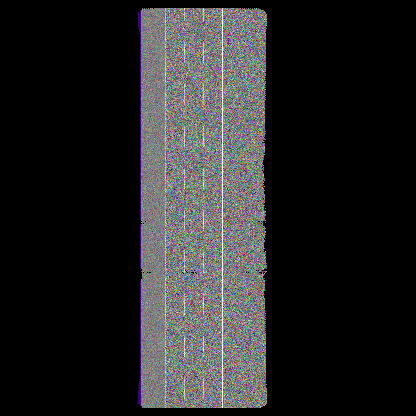

In [30]:
class_label = "road"
classMap = new_road_factory.classMap
threshold = 0.20
showInferenceOnImage(img, torch.sigmoid(outputs[0]), class_label, threshold, classMap)
#showInferenceOnImage(img, test_tensor, class_label, threshold, classMap)